群聚分析是一種非監督學習，可以發現資料內隱藏的結構。換言之，我們嘗試找出沒有類別標籤的數值，有沒有某種未知的分類方法。第一種方法稱為k-means演算法，其步驟如下:
1. 選擇$k$個點$\{\mu_j:j=1,2,...,k\}$作為初始群集中心，$k$為超參數，可自行決定
2. 每個數據點都會有一個離他最靠近的$\mu^{(j)}$，以此分成$k$群
3. 計算每一群的幾何中心
4. 重複步驟2與3直到群集分配不再改變，或達到使用者所定義的可容許誤差內
如果我們用歐式距離度量樣本空間，k-means演算法其實就是解一個最佳化以下的SSE(集群內誤差平方和)函數。
$$SSE=\sum_{i=1}^n\sum_{j=1}^kw^{(i,j)}||\mathbf{x}^{(i)}-\mathbf{\mu}^{(j)}||_2^2$$
其中
$$w^{(i,j)}=\left\{\begin{array}{ll} 
        1, & \text{ $\mathbf{x}^{(i,j)}$在群集$j$之中} \\
        0, & \text{ $\mathbf{x}^{(i,j)}$不在群集$j$之中}
    \end{array}\right. $$
我們先自製一個數據集來說明這個演算法。

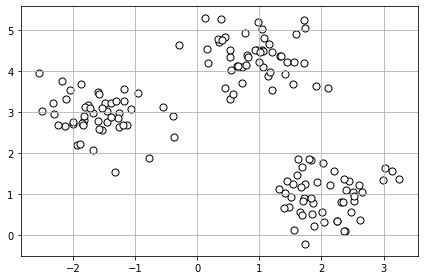

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)

plt.scatter(X[:, 0], X[:, 1], 
            c='white', marker='o', edgecolor='black', s=50)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_01.png', dpi=300)
plt.show()

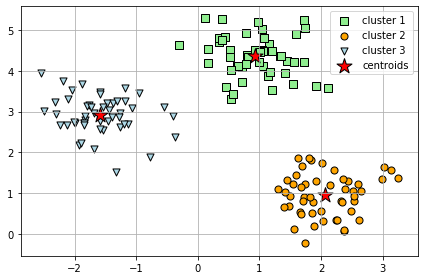

In [2]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,  # 假設分三群
            init='random', # 初始質心隨機找，可改為'k-means++'
            n_init=10,     # 重複執行演算法10次，並取10個模型中SSE最小的當作輸出
            max_iter=300,  # 最大迭代次數
            tol=1e-04,     # SSE可容許的誤差
            random_state=0)

y_km = km.fit_predict(X)

# 繪製分群結果
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_02.png', dpi=300)
plt.show()

k-means的缺點有計算量大，以及初始質心若隨機選可能導致收斂太慢。k-means++可解決這種問題。其步驟如下:
1. 令集合$M$表示質心的集合
2. 從輸入樣本中隨機取一個點作為第一個質心$\mathbf{\mu}^{(j)}$，並加入$M$中
3. 對不在$M$中的各個樣本點$\mathbf{x}^{(i)}計算出對$M$中所有質心的最小距離平方
4. 利用$$\frac{d(\mathbf{mu}^{(p)},M)^2}{\sum_id(\mathbf{x}^{(i)},M)^2}$$來選取下一個質心$\mathbf{mu}^{(p)}$
5. 重複步驟2~4直到選取了k個質心
6. 利用k-means演算法完成後續步驟

其在scikit-learn的調用只需把k-means中的init參數改成'k-means++'就好了

如果我們允許一個樣本點可以同時屬於兩個族群，那我們就稱之為$\textbf{鬆散集群}$或$\textbf{模糊集群}$。與之相對的是$\text{嚴格集群}$。實行鬆散集群的演算法中最有名的稱為FCM演算法(Fuzzy C-means)。其計算原理見課本p342~343。然而scikit learn並沒有這個實作演算法。建議下載fuzzy-c-means函式庫。

到底要分成幾群才是最好的結果呢?一個方法是來看看SSE對$k$值的變化，這種圖形稱為$\textbf{失真圖}$。理論上來說，$k$值越大SSE就越小，因此我們通常取圖形的"轉折點"來決定$k$。

Distortion: 72.48


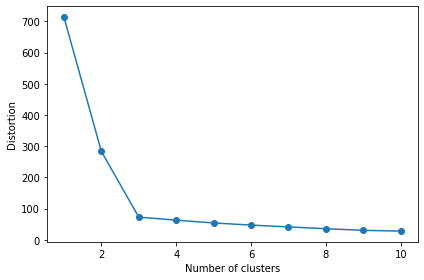

In [3]:
# k=3的SSE
print('Distortion: %.2f' % km.inertia_)

# 計算k=3~10的SSE
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

# 繪圖
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('images/11_03.png', dpi=300)
plt.show()

明顯地，$k=3$是一個轉折點，所以取$k=3$足矣。

另一種找$k$的方法是畫$\textbf{輪廓圖}$。首先要先計算單一樣本的$\textbf{輪廓係數}$(sihoutte coefficient)
1. 對每一樣本點$\mathbf{x^{(i)}}$，計算$\textbf{群集內聚性}a^{(i)}=$該樣本與同一群的其他樣本間的平均距離
2. 計算每一樣本點$\mathbf{x^{(i)}}$的$\textbf{群聚分離性}b^{(i)}=$與$\mathbf{x^{(i)}}$最相近集群中所有樣本的平均距離
3. 輪廓係數$$s^{(i)}=\frac{b^{(i)}-a^{(i)}}{\max\{b^{(i)},a^{(i)}}$$

根據這樣的定義，輪廓係數越接近1越好，因為這代表每個樣本都與同一群的樣本相近，與其他樣本相遠。這樣的觀念讓我們產生繪製$\textbf{輪廓係數圖}$的想法。我們某一群之中所有點的輪廓係數由高到低排列，並繪製一張長條圖。同時把其他群的長條圖並列顯示。所有輪廓係數的平均標記為虛線。

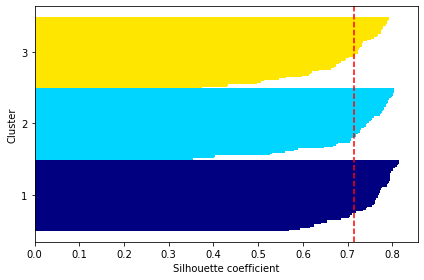

In [4]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_04.png', dpi=300)
plt.show()

上圖的輪廓係數離0非常遠，最大值接近1，因此是一個好的分群(至少對下面只分兩群的例子來說是)。

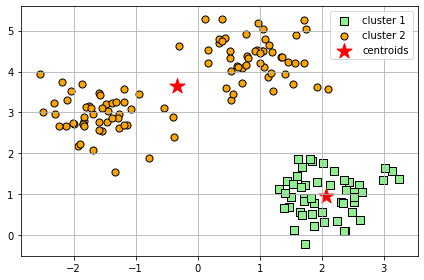

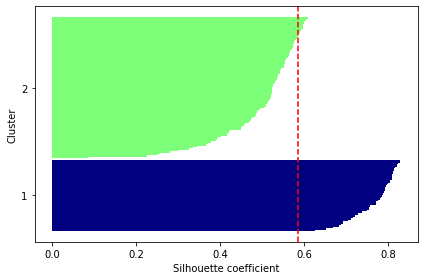

In [5]:
# 故意只分兩群
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            edgecolor='black',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            edgecolor='black',
            marker='o',
            label='cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_05.png', dpi=300)
plt.show()

# 只分兩群的輪廓圖
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_06.png', dpi=300)
plt.show()

輪廓圖的重要性在於，因為數據通常不會只有二維，因此無法繪製散佈圖。即使是二維也很難從散佈圖中一眼看出要分幾群為佳。因此我們通常用輪廓圖與失真圖來判斷分群結果的好壞。